In [1]:
import os
import pandas as pd
import janitor
import numpy as np

pd.set_option("display.max_columns", 100)

from utils.utils import save_mpl_fig
from utils.data_utils import lowess_ci
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook", font_scale=1.5, style="whitegrid")

FIGSAVEDIR = "../figs"
DATAPATH = "../adult-data"

In [2]:
# (fold cell) Load and prep web browsing data
# output = df with visits to adult sites
usecols_web_desktop = [
    "caseid",
    "category",
    "private_domain",
    "visit_duration",
    "visit_time_local",
]
usecols = [
    "caseid",
    "category",
    "private_domain",
    "page_duration",
    "session_start_time",
]

df = pd.concat(
    [
        # Get web_mobile
        pd.read_csv(
            os.path.join(
                DATAPATH, "output/realityMine_web_mobile_2022-06-01_2022-06-30.csv"
            ),
            usecols=usecols_web_desktop,
            low_memory=False,
        ),
        # Get web_desktop
        pd.read_csv(
            os.path.join(
                DATAPATH, "output/realityMine_web_desktop_2022-06-01_2022-06-30.csv"
            ),
            usecols=usecols_web_desktop,
            low_memory=False,
        ),
        # Get web
        (
            pd.read_csv(
                os.path.join(
                    DATAPATH, "output/realityMine_web_2022-06-01_2022-06-30.csv"
                ),
                usecols=usecols,
                low_memory=False,
            )
            # Renaming columns to be consistent w/ web_mobile & web_desktop
            .rename_column("session_start_time", "visit_time_local").rename_column(
                "page_duration", "visit_duration"
            )
        ),
    ]
)
print("output = df with web browses")
print(f"{len(df)=:,}")
df.head()

output = df with web browses
len(df)=6,297,382


,caseid,private_domain,category,visit_time_local,visit_duration
0,205323077,google.com,Search Engines and Portals,2022-05-31 23:52:37,2
1,205323077,coupons.com,"Business, Shopping",2022-06-01 01:07:35,457
2,205323077,google.com,Business,2022-06-01 01:15:12,55
3,205323077,coupons.com,"Business, Shopping",2022-06-01 01:16:07,2225
4,205323077,google.com,Search Engines and Portals,2022-06-01 04:38:10,10


## Top gaming and entertainment sites

### Duration

In [3]:
# Top games
(
    df.query("category.str.contains('games', case=False, na=False)")
    .groupby(["private_domain", "category"])["visit_duration"]
    .sum()
    .reset_index()
    .rename_column("visit_duration", "duration_games")
    .sort_values("duration_games", ascending=False)
    .head(20)
)

,private_domain,category,duration_games
641,twitch.tv,"Entertainment, Games, Streaming Media",497700
693,worldwinner.com,Games,458854
119,chumbacasino.com,"Gambling, Games",305032
326,jigsawexplorer.com,Games,266156
455,pch.com,"Business, Entertainment, Games",209239
68,bignox.com,"Games, Information Technology",197308
583,solitaired.com,Games,178512
602,steampowered.com,"Games, Shopping",154088
508,purecasinocash.co,"Gambling, Games",146392
116,chess.com,Games,143854


In [4]:
# Top entertainment
(
    df.query("category.str.contains('entertainment', case=False, na=False)")
    .groupby(["private_domain", "category"])["visit_duration"]
    .sum()
    .reset_index()
    .rename_column("visit_duration", "duration_entertainment")
    .sort_values("duration_entertainment", ascending=False)
    .head(20)
)

,private_domain,category,duration_entertainment
3651,youtube.com,"Entertainment, Streaming Media",16018151
1368,hideout.co,"Education, Entertainment, Streaming Media",5215472
1438,hulu.com,"Entertainment, Streaming Media",2913677
2088,netflix.com,"Entertainment, Streaming Media",2351316
3629,yahoo.com,"Entertainment, News and Media",1820021
1332,hbomax.com,Entertainment,897793
3270,twitch.tv,"Entertainment, Games, Streaming Media",497700
2490,readmanganato.com,Entertainment,484412
2283,peacocktv.com,Entertainment,473640
2676,showbox-movies.net,Entertainment,377568


In [5]:
# Top shop
(
    df.query("category.str.contains('shop', case=False, na=False)")
    .groupby(["private_domain", "category"])["visit_duration"]
    .sum()
    .reset_index()
    .rename_column("visit_duration", "duration_shop")
    .sort_values("duration_shop", ascending=False)
    .head(20)
)

,private_domain,category,duration_shop
154,amazon.com,Shopping,5044673
1153,ebay.com,Shopping,1199318
4082,walmart.com,Shopping,1166321
151,amazon.com,"Business, Shopping",955217
1243,etsy.com,Shopping,426413
632,capitaloneshopping.com,Shopping,394414
883,craigslist.org,"Messageboards and Forums, Shopping",379426
2534,mypoints.com,Shopping,309929
3664,target.com,Shopping,275935
3030,rakuten.com,"Business, Shopping",174099


### Adult with games, entertainment, shop

In [6]:
(
    df.query("category.str.contains('entertainment', case=False, na=False)")
    .query("category.str.contains('adult', case=False, na=False)")
    .groupby(["private_domain", "category"])["visit_duration"]
    .sum()
    .reset_index()
    .sort_values("visit_duration", ascending=False)
    .head(20)
)

,private_domain,category,visit_duration
110,thechive.com,"Adult, Entertainment",72879
101,redgifs.com,"Adult, Entertainment",26928
0,4chan.org,"Adult, Entertainment, Messageboards and Forums",26312
53,hentairead.com,"Adult, Entertainment",22878
49,hentaifox.com,"Adult, Entertainment",17856
83,nhentai.net,"Adult, Entertainment",15701
124,xxxdan.com,"Adult, Entertainment",11854
28,e-hentai.org,"Adult, Entertainment",10508
55,hpjav.tv,"Adult, Entertainment",9774
6,aznude.com,"Adult, Entertainment",7124


In [7]:
(
    df.query("category.str.contains('games', case=False, na=False)")
    .query("category.str.contains('adult', case=False, na=False)")
    .groupby(["private_domain", "category"])["visit_duration"]
    .sum()
    .reset_index()
    .sort_values("visit_duration", ascending=False)
    .head(20)
)

,private_domain,category,visit_duration
2,familysimulator.io,"Adult, Games",519
3,freesexgame.com,"Adult, Games",242
4,nutaku.net,"Adult, Games",134
1,cumshots.com,"Adult, Games",60
5,sexyfuckgames.com,"Adult, Games",56
0,bigdick.com,"Adult, Games",36
6,xvideos.com,"Adult, Entertainment, Games",3


In [8]:
(
    df.query("category.str.contains('shop', case=False, na=False)")
    .query("category.str.contains('adult', case=False, na=False)")
    .groupby(["private_domain", "category"])["visit_duration"]
    .sum()
    .reset_index()
    .sort_values("visit_duration", ascending=False)
    .head(20)
)

,private_domain,category,visit_duration
22,manyvids.com,"Adult, Shopping",18426
2,adameve.com,"Adult, Shopping",9434
33,victoriassecret.com,"Adult, Shopping",9294
12,honeyplaybox.com,"Adult, Shopping",5170
28,r18.com,"Adult, Business, Shopping",3802
19,livejasmin.com,"Adult, Shopping",1434
20,lovehoney.com,"Adult, Shopping",1406
27,playfulpromises.com,"Adult, Shopping",1272
25,pinkcherry.com,"Adult, Shopping",636
3,adultdvdempire.com,"Adult, Shopping",498


### Traffic

In [9]:
# Top games
(
    df.query("category.str.contains('games', case=False, na=False)")
    .groupby(["private_domain", "category"])
    .size()
    .reset_index()
    .rename_column(0, "traffic_games")
    .sort_values("traffic_games", ascending=False)
    .head(20)
)

,private_domain,category,traffic_games
455,pch.com,"Business, Entertainment, Games",12074
526,roblox.com,Games,7219
641,twitch.tv,"Entertainment, Games, Streaming Media",4971
693,worldwinner.com,Games,4962
602,steampowered.com,"Games, Shopping",3558
374,microsoft.com,"Games, Shopping",3316
522,rewardia.com,"Entertainment, Games",2823
155,dndbeyond.com,"Entertainment, Games",2608
178,epicgames.com,"Games, Shopping",2602
583,solitaired.com,Games,2183


In [10]:
# Top entertainment
(
    df.query("category.str.contains('entertainment', case=False, na=False)")
    .groupby(["private_domain", "category"])
    .size()
    .reset_index()
    .rename_column(0, "traffic_entertainment")
    .sort_values("traffic_entertainment", ascending=False)
    .head(20)
)

,private_domain,category,traffic_entertainment
3651,youtube.com,"Entertainment, Streaming Media",227981
3629,yahoo.com,"Entertainment, News and Media",39042
2274,pch.com,"Business, Entertainment, Games",12074
1368,hideout.co,"Education, Entertainment, Streaming Media",10818
1438,hulu.com,"Entertainment, Streaming Media",10433
2273,pch.com,"Business, Entertainment",9058
3630,yahoo.net,"Entertainment, News and Media",8459
3432,washingtonpost.com,"Entertainment, News and Media",7591
193,aol.com,"Business, Entertainment, News and Media",7394
1486,imdb.com,Entertainment,7035


In [11]:
# Top shop
(
    df.query("category.str.contains('shop', case=False, na=False)")
    .groupby(["private_domain", "category"])
    .size()
    .reset_index()
    .rename_column(0, "traffic_shop")
    .sort_values("traffic_shop", ascending=False)
    .head(20)
)

,private_domain,category,traffic_shop
154,amazon.com,Shopping,103487
1153,ebay.com,Shopping,28497
4082,walmart.com,Shopping,26489
632,capitaloneshopping.com,Shopping,23353
151,amazon.com,"Business, Shopping",19333
2534,mypoints.com,Shopping,18682
1243,etsy.com,Shopping,13468
3030,rakuten.com,"Business, Shopping",11505
883,craigslist.org,"Messageboards and Forums, Shopping",7219
3664,target.com,Shopping,5702


## Prep data

In [12]:
# Read in list of classified FP (false positives)
falsepositives = (pd
                  .read_csv("../data/false_positives_list.csv")
                  ["flagged as FP"].tolist()
                 )
falsepositives

['9gag.com',
 'sniffies.com',
 'f95zone.to',
 'silverdaddies.com',
 'ttcache.com',
 'xlviirdr.com',
 '4chan.org',
 'thechive.com',
 'victoriassecret.com',
 'usasexguide.nl',
 'xlviiirdr.com',
 'xxxjmp.com',
 'urbandictionary.com',
 'lpsg.com']

In [13]:
# (fold cell) Get data
DATAPATH_IND = "../data/individual_browsing_data.csv"
df_ind = (
    pd.read_csv(DATAPATH_IND)
    # Normalize seconds to hours
    .assign(
        duration_adult=lambda df: df.duration_adult / 3600,
        duration_nonadult=lambda df: df.duration_nonadult / 3600,
    )
    # ==========================================================
    # Get pure adult duration
    .merge(
        (
            df
            .query("category=='Adult'")
            .query("private_domain not in @falsepositives")
            .groupby("caseid")["visit_duration"]
            .sum()
            .reset_index()
            .rename_column("visit_duration", "duration_pure_adult")
        ),
        how="left",
        on="caseid",
        validate="1:1",
    )
    # ==========================================================
    # Get games sites duration
    .merge(
        (
            df
            .query("category.str.contains('games', case=False, na=False)")
            .query("~category.str.contains('games', case=False)")
            .groupby("caseid")["visit_duration"]
            .sum()
            .reset_index()
            .rename_column("visit_duration", "duration_games")
        ),
        how="left",
        on="caseid",
        validate="1:1",
    )
    # ==========================================================
    # Get adult games sites duration
    .merge(
        (
            df
            .query("category.str.contains('games', case=False, na=False)")
            .query("category.str.contains('adult', case=False, na=False)")
            .groupby("caseid")["visit_duration"]
            .sum()
            .reset_index()
            .rename_column("visit_duration", "duration_adult_games")
        ),
        how="left",
        on="caseid",
        validate="1:1",
    )    
    # ==========================================================
    # Get entertainment sites duration
    .merge(
        (
            df
            .query("category.str.contains('entertainment', case=False, na=False)")
            .query("~category.str.contains('adult', case=False, na=False)")
            .groupby("caseid")["visit_duration"]
            .sum()
            .reset_index()
            .rename_column("visit_duration", "duration_entertainment")
        ),
        how="left",
        on="caseid",
        validate="1:1",
    )
    # ==========================================================
    # Get adult entertainment sites duration
    .merge(
        (
            df
            .query("category.str.contains('entertainment', case=False, na=False)")
            .query("category.str.contains('adult', case=False, na=False)")
            .groupby("caseid")["visit_duration"]
            .sum()
            .reset_index()
            .rename_column("visit_duration", "duration_adult_entertainment")
        ),
        how="left",
        on="caseid",
        validate="1:1",
    )    
    # ==========================================================
    # Get shopping sites duration
    .merge(
        (
            df
            .query("category.str.contains('shopping', case=False, na=False)")
            .query("~category.str.contains('adult', case=False, na=False)")
            .groupby("caseid")["visit_duration"]
            .sum()
            .reset_index()
            .rename_column("visit_duration", "duration_shop")
        ),
        how="left",
        on="caseid",
        validate="1:1",
    )
    # ==========================================================
    # Get adult shopping sites duration
    .merge(
        (
            df
            .query("category.str.contains('shopping', case=False, na=False)")
            .query("category.str.contains('adult', case=False, na=False)")
            .groupby("caseid")["visit_duration"]
            .sum()
            .reset_index()
            .rename_column("visit_duration", "duration_adult_shop")
        ),
        how="left",
        on="caseid",
        validate="1:1",
    )
    # ==========================================================
    .assign(
#         # Missing as zeroes
#         **{k: lambda df_, col=k: df_[col].fillna(0) for k in 
#             ["duration_adult_entertainment", "duration_entertainment", "duration_adult_games", 
#              "duration_games", "duration_adult_shop", "duration_shop",]},
        # Compute proportions
        prop_games=lambda df_: 100 * (df_["duration_games"] / df_["duration"]),
        prop_adult_games=lambda df_: 100 * (df_["duration_adult_games"] / df_["duration"]),
        prop_entertainment=lambda df_: 100 * (df_["duration_entertainment"] / df_["duration"]),
        prop_adult_entertainment=lambda df_: 100 * (df_["duration_adult_entertainment"] / df_["duration"]),
        prop_shop=lambda df_: 100 * (df_["duration_shop"] / df_["duration"]),
        prop_adult_shop=lambda df_: 100 * (df_["duration_adult_shop"] / df_["duration"]),
        prop_pure_adult=lambda df_: 100 * (df_["duration_pure_adult"] / df_["duration"]),
    )
    # ==========================================================
    # Normalize duration
    .assign(        
        **{k: lambda df_, col=k: df_[col]/3600 for k in 
            ["duration_adult_entertainment", "duration_entertainment", "duration_adult_games", 
             "duration_games", "duration_adult_shop", "duration_shop", "duration_pure_adult"]},)
)
assert (df_ind["duration_adult"] >= df_ind["duration_pure_adult"]).any()
df_ind

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,duration,prop_adult_duration,yes_visit_adults,race2,cohort,age,age2,educ2,duration_pure_adult,duration_games,duration_adult_games,duration_entertainment,duration_adult_entertainment,duration_shop,duration_adult_shop,prop_games,prop_adult_games,prop_entertainment,prop_adult_entertainment,prop_shop,prop_adult_shop,prop_pure_adult
0,200661421,1963,2,1,4,3,3,1,39,2,D,0.0,1728.0,1728.0,0.000000,0.0,0.000000,21.567222,77642.0,0.000000,0.0,1,1960,60,3600,4,NaN,NaN,NaN,0.447778,NaN,9.431667,NaN,NaN,NaN,2.076196,NaN,43.731486,NaN,NaN
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN,243.0,3994.0,4237.0,5.735190,NaN,7.208889,65.054444,260148.0,9.975860,1.0,5,1990,31,961,4,7.207778,NaN,NaN,2.401111,0.0,2.130000,NaN,NaN,NaN,3.322724,0.0,2.947553,NaN,9.974322
2,200953869,1959,2,1,5,2,7,2,42,1,R,0.0,20.0,20.0,0.000000,1.0,0.000000,0.328333,1182.0,0.000000,0.0,1,1960,64,4096,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201302005,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307,NaN,1.712778,6.626389,30021.0,20.538956,1.0,2,1970,57,3249,3,NaN,NaN,NaN,0.680833,NaN,0.471944,1.712778,NaN,NaN,8.164285,NaN,5.659372,20.538956,NaN
4,201590505,1977,1,4,5,3,3,1,6,4,D,0.0,11086.0,11086.0,0.000000,0.0,0.000000,106.433611,383161.0,0.000000,0.0,4,1980,46,2116,4,NaN,NaN,NaN,12.668611,NaN,3.080556,NaN,NaN,NaN,11.902829,NaN,2.894345,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1802885,1935,1,1,6,4,5,2,12,3,R,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1,1940,88,7744,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1196,1809723,1943,1,1,2,1,1,1,51,3,D,0.0,9805.0,9805.0,0.000000,0.0,0.000000,353.503611,1272613.0,0.000000,0.0,1,1940,80,6400,2,NaN,NaN,NaN,85.562500,NaN,33.861111,NaN,NaN,NaN,24.204137,NaN,9.578717,NaN,NaN
1197,1827351,1947,1,1,5,3,4,1,31,2,I,0.0,543.0,543.0,0.000000,NaN,0.000000,6.646944,23929.0,0.000000,0.0,1,1950,76,5776,4,NaN,NaN,NaN,2.779167,NaN,NaN,NaN,NaN,NaN,41.811191,NaN,NaN,NaN,NaN
1198,1924249,1980,1,7,4,2,7,2,6,4,R,182.0,21379.0,21561.0,0.844117,1.0,0.581667,86.076667,311970.0,0.671218,1.0,5,1980,43,1849,4,0.172222,NaN,NaN,11.455833,NaN,3.229444,NaN,NaN,NaN,13.219540,NaN,3.726640,NaN,0.198737


## Lowess

In [14]:
LOWESS_OPTS = dict(
    frac=0.5,
    it=10,
    delta=0.0,
    return_sorted=True,
)
LINEPLOT_OPTS = dict(c=".3", linewidth=4)
CI_PLOT_OPTS = dict(alpha=0.2, color="b")

### Percentage of time

In [15]:
pairs = [
    # All adult vs non-adult leisure
    ("prop_adult_duration", "prop_entertainment"),
    ("prop_adult_duration", "prop_shop"),
    # Pure adult vs adult-related leisure
    ("prop_pure_adult", "prop_adult_entertainment"),
    ("prop_pure_adult", "prop_adult_shop"),    
    # Pure adult vs nonadult-related leisure
    ("prop_pure_adult", "prop_entertainment"),
    ("prop_pure_adult", "prop_shop"),        
    # Adult-related leisure vs Non-adult-related leisure
    ("prop_entertainment", "prop_adult_entertainment"),
    ("prop_shop", "prop_adult_shop"),
    # Within adult-related leisure
    ("prop_adult_entertainment", "prop_adult_shop"),
    # Within non adult-related leisure
    ("prop_entertainment", "prop_shop"),
]
len(pairs)

10

In [16]:
VARLABEL_DICT = dict(
    prop_adult_duration="% All adult content",
    prop_entertainment="% Non-adult entertainment",
    prop_shop="% Non-adult shopping",
    prop_pure_adult="% Pure adult content",
    prop_adult_entertainment="% Adult entertainment",
    prop_adult_shop="% Adult shopping",
    prop_adult_games="% Adult games",
    prop_games="% Non-adult games",
)

1 prop_adult_duration prop_entertainment


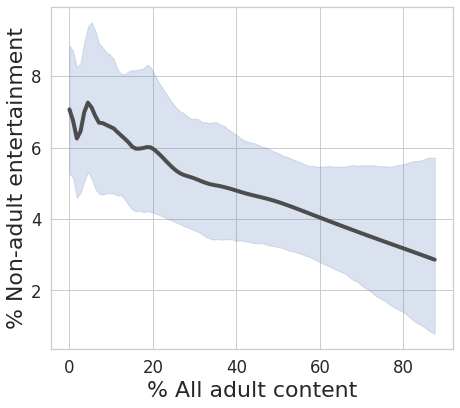

2 prop_adult_duration prop_shop


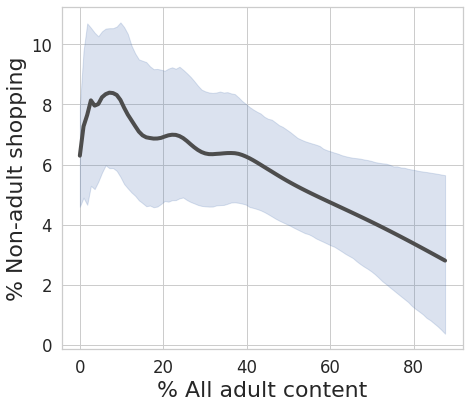

3 prop_pure_adult prop_adult_entertainment


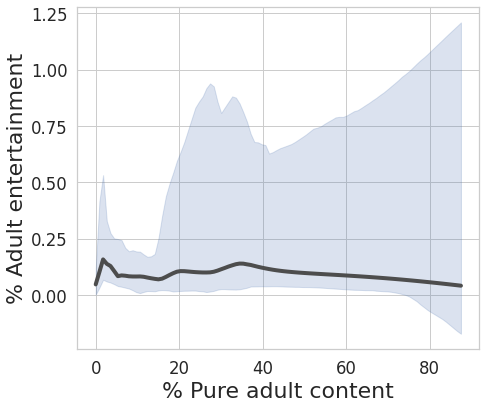

4 prop_pure_adult prop_adult_shop


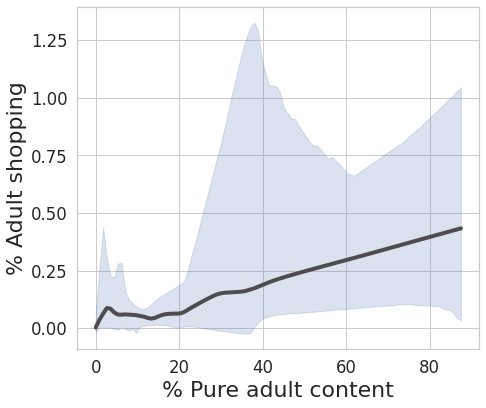

5 prop_pure_adult prop_entertainment


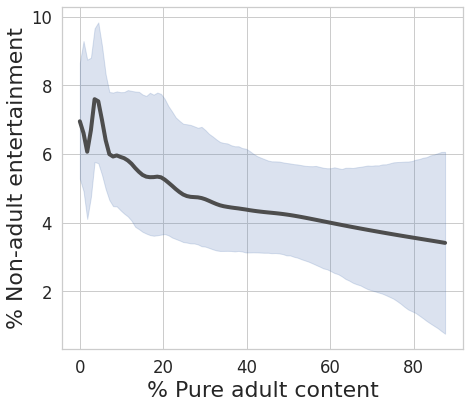

6 prop_pure_adult prop_shop


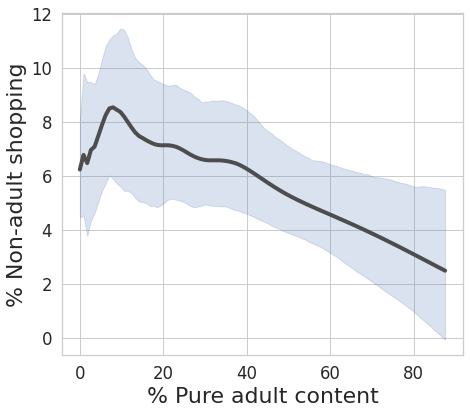

7 prop_entertainment prop_adult_entertainment


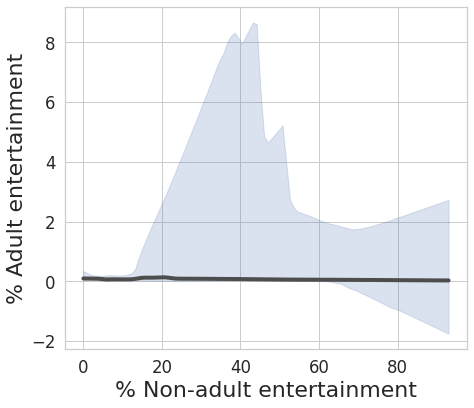

8 prop_shop prop_adult_shop


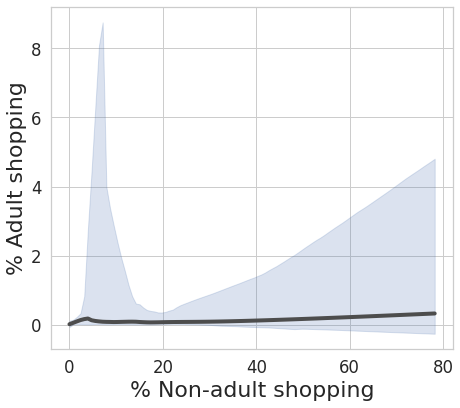

9 prop_adult_entertainment prop_adult_shop


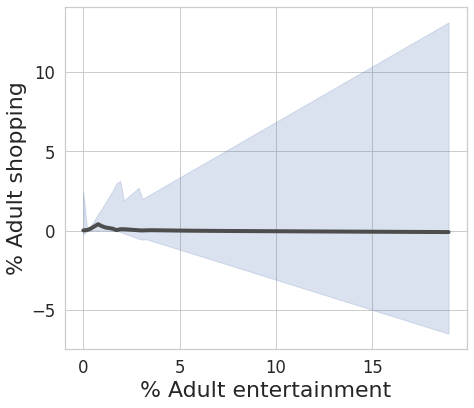

10 prop_entertainment prop_shop


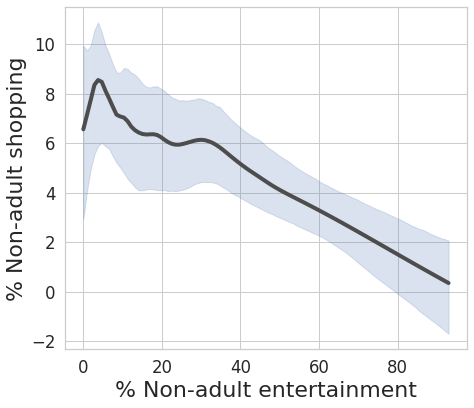

In [17]:
scale = 0.9
for ix, xy in enumerate(pairs):
    xvar, yvar = xy
    print(ix+1, xvar, yvar)
    _df = df_ind.query("duration_adult>0")
    x = _df[xvar].values
    y = _df[yvar].values
    smoothed, eval_x, bottom, top = lowess_ci(x, y, N=1000, lowess_kw=LOWESS_OPTS)
    _, ax = plt.subplots(figsize=(8 * scale, 7 * scale), facecolor="white")
    ax.plot(eval_x, smoothed, **LINEPLOT_OPTS)
    ax.fill_between(eval_x, bottom, top, **CI_PLOT_OPTS)
    ax.set_xlabel(VARLABEL_DICT[xvar], fontsize=22)
    ax.set_ylabel(VARLABEL_DICT[yvar], fontsize=22)
    plt.locator_params(nbins=7) 
    save_mpl_fig(f"../figs/tu_{yvar}-{xvar}")
    plt.show()

### Hours

In [18]:
pairs = [
    # All adult vs non-adult leisure
    ("duration_adult", "duration_entertainment"),
    ("duration_adult", "duration_shop"),
    # Pure adult vs adult-related leisure
    ("duration_pure_adult", "duration_adult_entertainment"),
    ("duration_pure_adult", "duration_adult_shop"),    
    # Pure adult vs nonadult-related leisure
    ("duration_pure_adult", "duration_entertainment"),
    ("duration_pure_adult", "duration_shop"),        
    # Adult-related leisure vs Non-adult-related leisure
    ("duration_entertainment", "duration_adult_entertainment"),
    ("duration_shop", "duration_adult_shop"),
    # Within adult-related leisure
    ("duration_adult_entertainment", "duration_adult_shop"),
    # Within non adult-related leisure
    ("duration_entertainment", "duration_shop"),
]
len(pairs)

10

In [19]:
VARLABEL_DURATION_DICT = dict(
    duration_adult="Hours on all adult content",
    duration_entertainment="Hours on non-adult entertainment",
    duration_shop="Hours on non-adult shopping",
    duration_pure_adult="Hours on pure adult content",
    duration_adult_entertainment="Hours on adult entertainment",
    duration_adult_shop="Hours on adult shopping",
    prop_adult_games="Hours on adult games",
)

1 duration_adult duration_entertainment


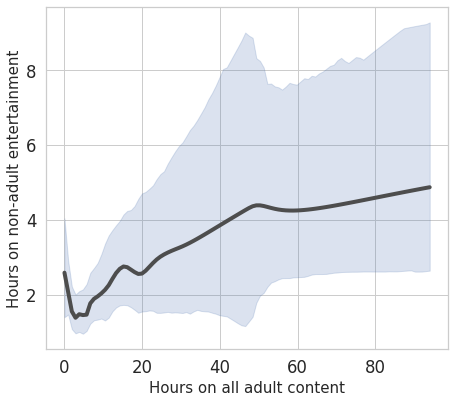

2 duration_adult duration_shop


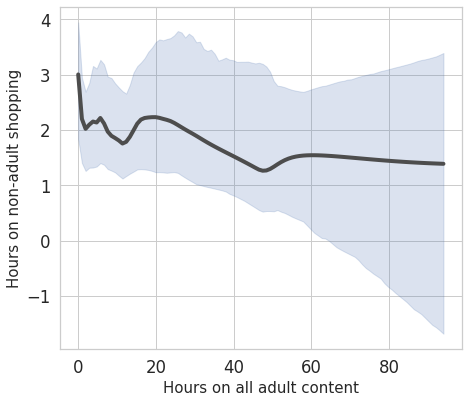

3 duration_pure_adult duration_adult_entertainment


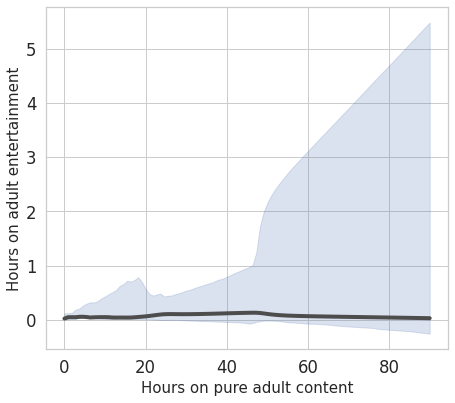

4 duration_pure_adult duration_adult_shop


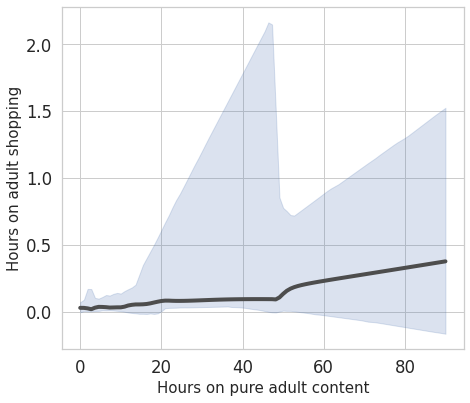

5 duration_pure_adult duration_entertainment


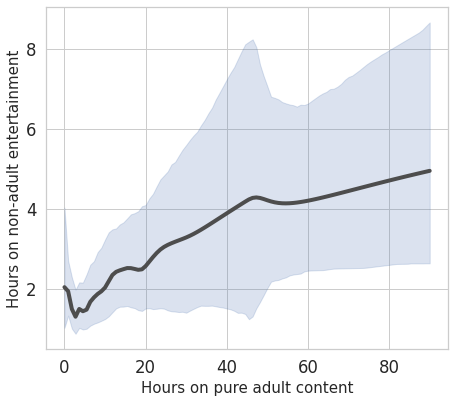

6 duration_pure_adult duration_shop


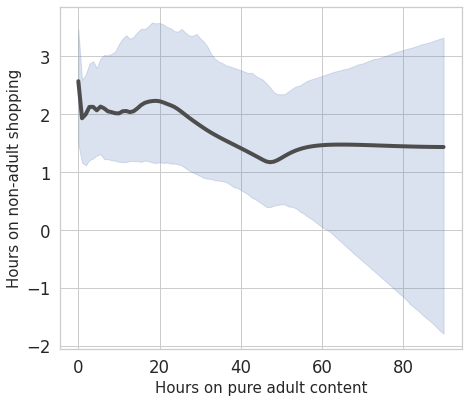

7 duration_entertainment duration_adult_entertainment


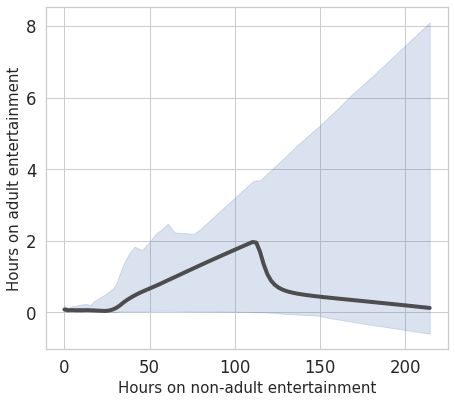

8 duration_shop duration_adult_shop


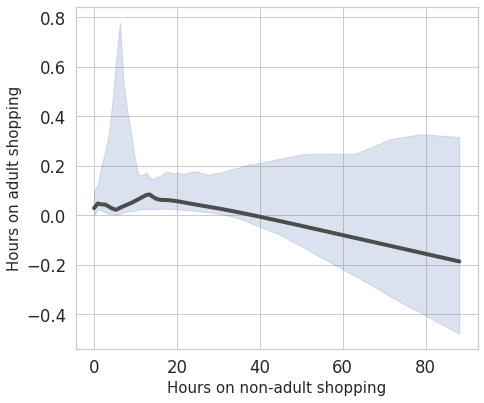

9 duration_adult_entertainment duration_adult_shop


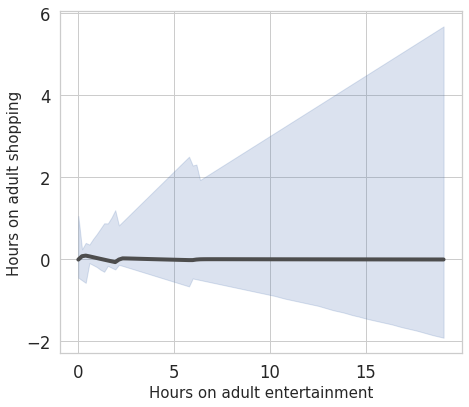

10 duration_entertainment duration_shop


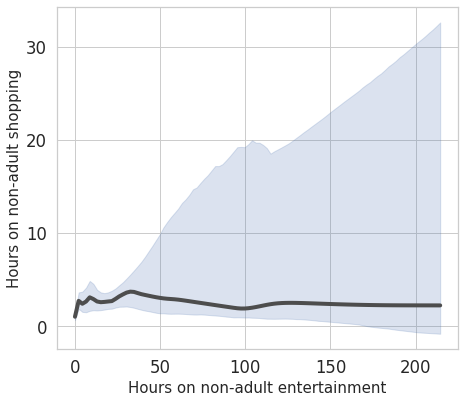

In [20]:
scale = 0.9
for ix, xy in enumerate(pairs):
    xvar, yvar = xy
    print(ix+1, xvar, yvar)
    _df = df_ind.query("duration_adult>0")
    x = _df[xvar].values
    y = _df[yvar].values
    smoothed, eval_x, bottom, top = lowess_ci(x, y, N=1000, lowess_kw=LOWESS_OPTS)
    _, ax = plt.subplots(figsize=(8 * scale, 7 * scale), facecolor="white")
    ax.plot(eval_x, smoothed, **LINEPLOT_OPTS)
    ax.fill_between(eval_x, bottom, top, **CI_PLOT_OPTS)
    ax.set_xlabel(VARLABEL_DURATION_DICT[xvar], fontsize=15)
    ax.set_ylabel(VARLABEL_DURATION_DICT[yvar], fontsize=15)
    plt.locator_params(nbins=7) 
    save_mpl_fig(f"../figs/tu_{yvar}-{xvar}")
    plt.show()